In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



170498071/170498071 [==============================] - 2s 0us/step


In [3]:
input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [4]:
autoencoder.fit(x_train, x_train,  # Training to reconstruct input
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
196/196 [==============================] - 179s 907ms/step - loss: 0.5907 - val_loss: 0.5705
Epoch 2/50
196/196 [==============================] - 169s 860ms/step - loss: 0.5668 - val_loss: 0.5656
Epoch 3/50
196/196 [==============================] - 179s 912ms/step - loss: 0.5637 - val_loss: 0.5640
Epoch 4/50
196/196 [==============================] - 174s 887ms/step - loss: 0.5623 - val_loss: 0.5634
Epoch 5/50
196/196 [==============================] - 172s 879ms/step - loss: 0.5613 - val_loss: 0.5643
Epoch 6/50
196/196 [==============================] - 177s 905ms/step - loss: 0.5606 - val_loss: 0.5611
Epoch 7/50
196/196 [==============================] - 171s 873ms/step - loss: 0.5601 - val_loss: 0.5603
Epoch 8/50
196/196 [==============================] - 171s 875ms/step - loss: 0.5595 - val_loss: 0.5611
Epoch 9/50
196/196 [==============================] - 171s 872ms/step - loss: 0.5592 - val_loss: 0.5602
Epoch 10/50
196/196 [==============================] - 168s 857m

313/313 [==============================] - 16s 47ms/step


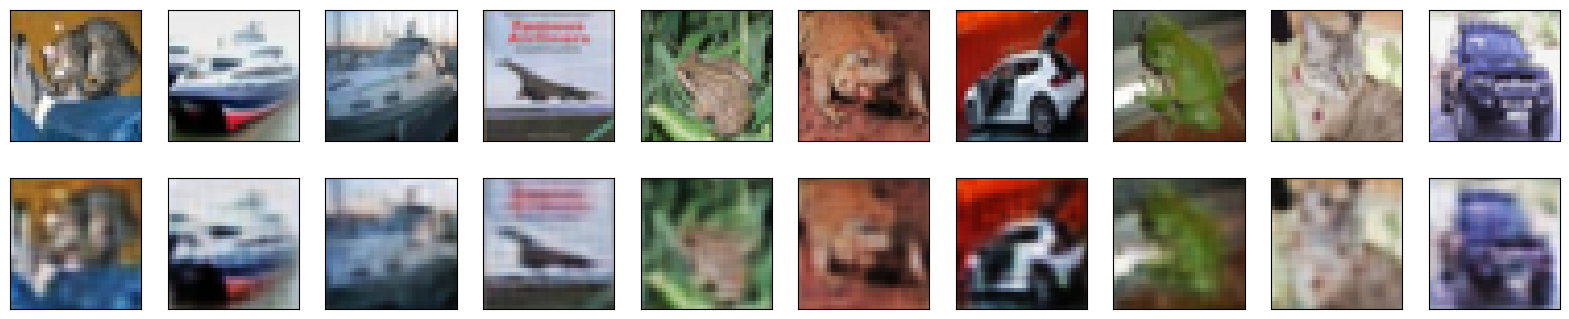

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [8]:
# Calculate MSE for training data
reconstructed_train = autoencoder.predict(x_train)
train_mse = np.mean(np.power(x_train - reconstructed_train, 2), axis=(1, 2, 3))

# Calculate the mean and standard deviation of the training MSE
mean_train_mse = np.mean(train_mse)
std_train_mse = np.std(train_mse)

# Set the threshold as mean plus 2 or 3 times the standard deviation (based on how sensitive you want it to be)
threshold = mean_train_mse + 3 * std_train_mse


1563/1563 [==============================] - 52s 33ms/step


313/313 [==============================] - 10s 30ms/step


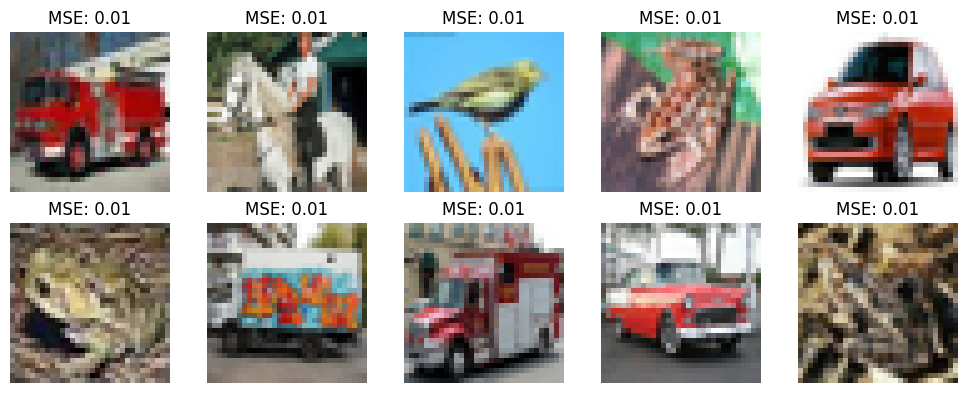

In [9]:
# Predict on the test set
reconstructed_test = autoencoder.predict(x_test)
test_mse = np.mean(np.power(x_test - reconstructed_test, 2), axis=(1, 2, 3))

# Detect anomalies by checking which test MSEs exceed the threshold
anomalies = x_test[test_mse > threshold]

# Visualize detected anomalies
plt.figure(figsize=(10, 4))
num_anomalies_to_show = 10
for i, idx in enumerate(np.where(test_mse > threshold)[0][:num_anomalies_to_show]):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(anomalies[i])
    plt.title(f"MSE: {test_mse[idx]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


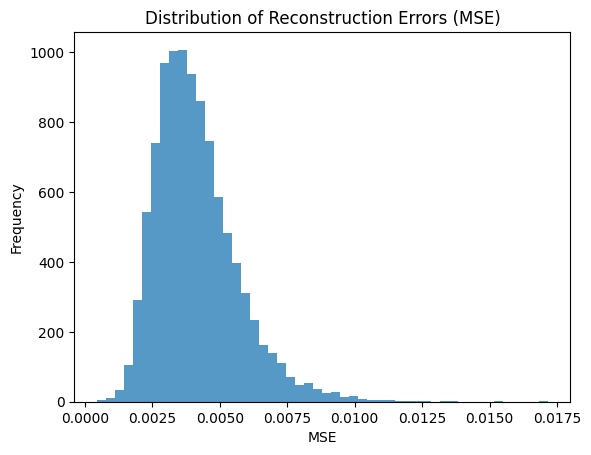

Thresholds to consider based on percentiles: [0.006098665110766888, 0.006951454700902105, 0.008958810903131963]


In [10]:
import matplotlib.pyplot as plt

# Assuming `test_mse` contains the MSE values for the test set
plt.hist(test_mse, bins=50, alpha=0.75)
plt.title('Distribution of Reconstruction Errors (MSE)')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Experiment with different thresholds
threshold_values = [np.percentile(test_mse, 90), np.percentile(test_mse, 95), np.percentile(test_mse, 99)]
print("Thresholds to consider based on percentiles:", threshold_values)
